<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb"><< 241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2</a><span style="float:right;"><a href="./251_Sentinel-3_OLCI_radiance_L1_load_browse.ipynb">251 - Sentinel-3 OLCI - Radiances - Level 1 >></a></span>

<div class="alert alert-block alert-success">
<b>20 - DATA DISCOVERY</b></div>

<div class="alert alert-block alert-success">

<b>SEE ALSO</b>

* **30 - CASE STUDIES**
  - [318 - Indonesian fires 2020](../30_case_studies/318_fire_indonesia_2020.ipynb)
  - [319 - Portugal fires 2020](../30_case_studies/319_fire_portugal_2020.ipynb)

</div>

<hr>

# 2.4.2 Copernicus Sentinel-5P TROPOMI UV Aerosol Index (UVAI)

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on: `Ozone`, `NO`<sub>`2`</sub>, `SO`<sub>`2`</sub>, `Formaldehyde`, `Aerosol`, `Carbon monoxide`, `Methane` and `Clouds`.

For fire monitoring , the `TROPOMI UV Aerosol Index (UVAI)` data can be used. 

Positive values of UVAI (typically > abt. 1.0) indicate the presence of absorbing-type aerosols: 
- `smoke from forest fires`, 
- `volcanic ash`, or 
- `desert dust`. 

The UVAI value depends on (i) the amount of aerosols, (ii) height of the aerosol plume, and (iii) aerosol type. 

Typically UVAI is more sensitive to the elevated aerosol layers and hence it can be used to track the (long-range) transport of smoke from fires. To asses the ambient air quality near the surface, other aerosol observations, such as AOD from satellites, in situ aerosol observations or modeled surface concentrations are recommended to be used together with UVAI. 

### This module has the following outline:
* [1 - Load and browse Sentinel-5P TROPOMI UV Aerosol Index data](#load_browse_uvai)
* [2 - Select an aerosol index variable](#select_uvai)
* [3 - Read and apply the quality flag to the UVAI data](#quality_flag_uvai)
* [4 - Visualize the Sentinel-5P TROPOMI UV Aerosol Index values](#visualize_uvai)


<hr>

#### Load required libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from netCDF4 import Dataset
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [3]:
%run ../functions.ipynb

<hr>

## <a id='load_browse_uvai'></a>Load and browse Sentinel-5P TROPOMI UV Aerosol Index data

A Sentinel-5P TROPOMI Aerosol Index Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load a `netCDF` file with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 15 August 2020 and inspect the data structure:

In [4]:
s5P_mf = xr.open_dataset('../eodata/sentinel5p/UVAI/2020/09/19/S5P_OFFL_L2__AER_AI_20200919T055125_20200919T073254_15207_01_010302_20200920T194235.nc', group='PRODUCT')
s5P_mf

<xarray.Dataset>
Dimensions:                          (corner: 4, ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.172e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2020-09-19
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

<br>

## <a id='select_uvai'></a>Select an `aerosol index` variable

The Sentinel-5P TROPOMI aerosol index data provide the Aerosol Index for two different wavelength pairs: 
- `340_380 nm`
- `354_388 nm` 

For both parameters the interpretation of the index value is the same. 

Let us use the aerosol index for the wavelength pair 340_380 nm. The variable name is `aerosol_index_340_380`. You can select the variable from the data set, together with the geo-coordinates as follows:

In [5]:
uvai = s5P_mf.aerosol_index_340_380[0,:,:]
lat = uvai.latitude
lon = uvai.longitude


<br>

## <a id='quality_flag_uvai'></a>Read and apply the `Quality Flag` to the UVAI data

Another important parameter to read is the general quality flag called `qa_value`. The quality flag removes the sun glint pixels, where "falsely" high positive UVAI values over sea can be detected. In order to exclude sun glint, it is recommended to use only values where the `qa_value` is higher than 0.8. 

In [6]:
qa=s5P_mf.qa_value[0,:,:]

<br>

The final step before plotting is to mask the aerosol index data based on the qa mask. You filter data with the `xarray` function `where`.

In [7]:
uvai_masked=uvai.where(qa > 0.8)

<br>

## <a id='visualize_uvai'></a>Visualize the Sentinel-5P TROPOMI `UV Aerosol Index` values

Before you plot the data, you can define the geographical extent you wish to plot. Let us define a bounding box for  the southern part of Borneo, Indonesia.

In [8]:
latmin = -5
latmax = 0.
lonmin = 105.
lonmax = 120.

<br>

You can use the function [visualize_pcolormesh](./function.ipynb#visualize_pcolormesh) to plot the `Aerosol Index for the wavelength pair 340 to 380 nm`

The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 380 and 340 nm'}>)

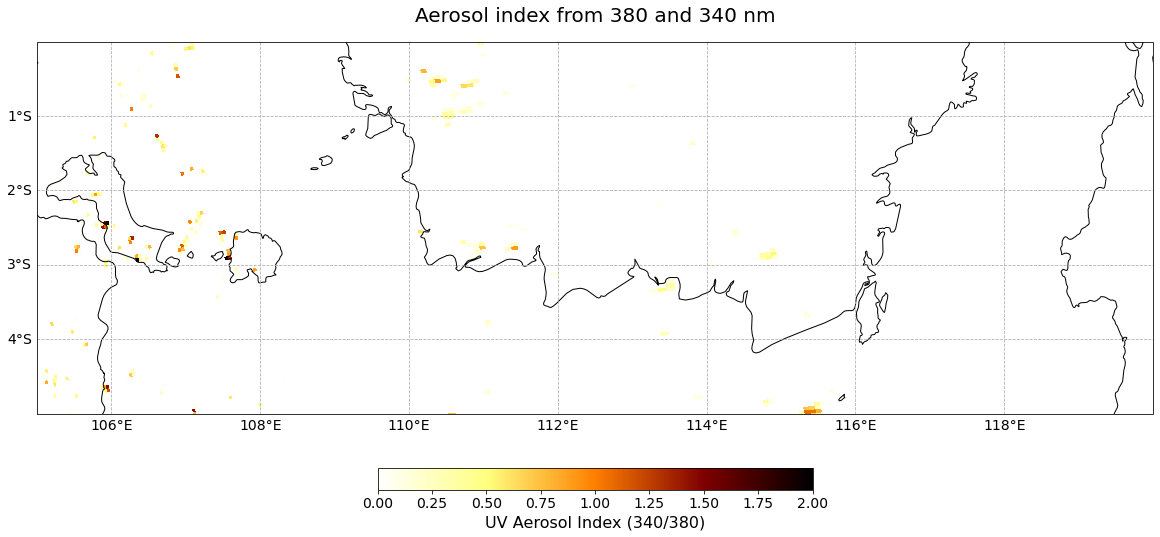

In [9]:
visualize_pcolormesh(data_array=uvai_masked,
                     longitude=lon,
                     latitude=lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit= 'UV Aerosol Index (340/380)',
                     long_name=uvai.long_name,
                     vmin=0, 
                     vmax=2,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb"><< 241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2</a><span style="float:right;"><a href="./251_Sentinel-3_OLCI_radiance_L1_load_browse.ipynb">251 - Sentinel-3 OLCI - Radiances - Level 1 >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>